In [1]:
# setting seeds, checking for tf 2.x
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import numpy as np
import tensorflow as tf
np.random.seed(42)
print(f'TF version: {tf.__version__}')

TF version: 2.1.0


# Soft-Margin SVM

> soft-margin SVM with scikit-learn and naive gradient-descent implementation in PyTorch and Tensorflow 2.x in order to get used to the frameworks

![SVM](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/512px-SVM_margin.png)

Soft-Margin SVM objective with regularization parameter $C > 0$ given data $((x_i,y_i))_{i=1}^n$:

$$ \min_{w,b}  \ \lVert w \rVert^2 + C\left[\frac 1 n \sum_{i=1}^n \underbrace{\max\left(0, 1 - y_i(w\cdot x_i - b)\right)}_{\text{hinge loss}} \right]$$


- $C$ represents a trade-off between increasing the margin size (smaller $C$) and ensuring that the $x_{i}$ lie on the correct side of the margin (larger $C$)

- After finding (approximate) minimizer $\hat{w}, \hat{b}$, the classifier is given by $x \mapsto \operatorname{sgn}(\hat{w} x-\hat{b})$. 

## Data

We use a predefined scikit-learn dataset.

In [2]:
from sklearn.datasets import make_blobs

X, Y = make_blobs(n_samples=200, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
Y[Y == 0] = -1 #to have +/- 1 labels

Let us plot the data (see the `svm_utils` module).

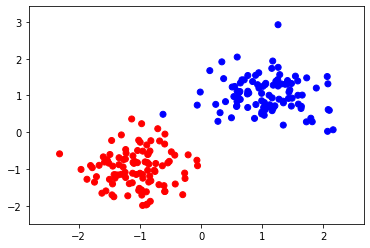

In [3]:
from svm_utils import plot
plot(X, Y)

## Scikit-Learn

... very easy to use!

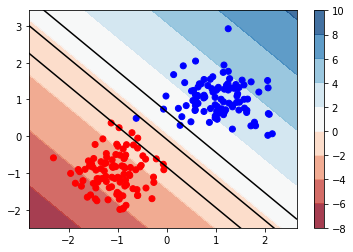

In [4]:
from sklearn.svm import LinearSVC

clf = LinearSVC(penalty='l2', loss='hinge', C=1.0)
clf.fit(X, Y)

plot(X, Y, W=clf.coef_.T, b=-clf.intercept_)

## Naive PyTorch and TensorFlow gradient descent

**Disclaimer**: 
- This is just for the purpose of getting used to the [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation) of PyTorch and Tensorflow

- Usually, one does **not** solve the SVM objective using plain gradient descent, but, e.g. using [quadratic programming, interior-point methods, sub-gradient/coordinate descent, sequential minimal optimization](https://en.wikipedia.org/wiki/Support-vector_machine#Implementation)

### Model, Data

We cast the arrays to 32-bit float and reshape Y to a 2D array.

In [5]:
Y_2d = Y[:,np.newaxis].astype('f') 
print(f' Y shape: {Y.shape}, Y_2d shape: {Y_2d.shape}')
X = X.astype('f') 

# tensorflow
import tensorflow as tf # actually already imported in the beginning
X_t = tf.constant(X)
Y_t = tf.constant(Y_2d)

# pytorch
import torch
X_p = torch.tensor(X) 
Y_p = torch.tensor(Y_2d) 

 Y shape: (200,), Y_2d shape: (200, 1)


### Model

To compare TF and PyTorch we use numpy random initializations. Note that we want to compute gradients w.r.t. to W and b later.

In [6]:
W = np.random.rand(2,1).astype('f') 
b = np.random.rand(1,1).astype('f') 

# tensorflow
W_t = tf.Variable(W)
b_t = tf.Variable(b)

# pytorch
W_p = torch.tensor(W, requires_grad=True) 
b_p = torch.tensor(b, requires_grad=True)

### Loss

Let us define the objective

$$ \min_{w,b}  \ \lVert w \rVert^2 + C\left[\frac 1 n \sum_{i=1}^n \underbrace{\max\left(0, 1 - y_i(w\cdot x_i - b)\right)}_{\text{hinge loss}} \right]$$.

In [7]:
# tensorflow 
def soft_margin_loss_t(C=1.):
    pred = X_t @ W_t - b_t # @ denotes the usual matrix product
    hinge = tf.math.reduce_mean(tf.keras.losses.hinge(Y_t, pred))
    tikhonov = tf.math.reduce_sum(0.5*(W_t**2)) # one could understand this as a L2/Tikhonov regularization
    return C*hinge + tikhonov

# pytorch
def hinge_loss(t):
    loss = 1-t 
    loss[loss < 0] = 0 # PyTorch supports 'numpy-style' indexing
    return loss

def soft_margin_loss_p(C=1.):
    pred = X_p @ W_p - b_p 
    hinge = hinge_loss(pred*Y_p).mean()
    tikhonov = 0.5*(W_p**2).sum()
    return C*hinge + tikhonov

Lets plot the hinge loss:

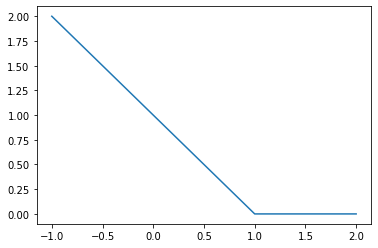

In [8]:
from matplotlib import pyplot as plt

t = torch.linspace(-1,2)
plt.plot(t, hinge_loss(t)) # PyTorch works well with matplotlib
plt.show() 

### Metric

We want to compute the accuracy of our models.

In [9]:
# tensorflow
def accuracy_t():
    pred = tf.math.sign(X_t @ W_t - b_t)
    return tf.metrics.Accuracy()(Y_t, pred)

# pytorch
def accuracy_p():
    pred = torch.sign(X_p @ W_p - b_p)
    return (pred == Y_p).float().sum()/len(Y_p)

print()

Lets check that the inital loss and the initial accuracy is equal.

In [10]:
print(f'Loss/Acc. TF: {soft_margin_loss_t()}/{accuracy_t()}, Loss/Acc. PyTorch: {soft_margin_loss_p()}/{accuracy_p()}')

Loss/Acc. TF: 0.5553568005561829/0.8650000095367432, Loss/Acc. PyTorch: 0.5553567409515381/0.8650000095367432


### Gradient Descent

Let use automatic differentiation (AD) to perform gradient descent.

**Tensorflow:** GradientTape ... records operations for AD if at least one of their inputs is being "watched" (e.g. a `tf.Variable`)

**PyTorch:** loss.backward() ... compute gradients of `loss` w.r.t. tensors occuring in the computational graph of loss for which `requires_grad=True`

In [11]:
# tensorflow
def gradient_step_t(lr=0.1, C=1.):
    with tf.GradientTape() as tape: 
        loss = soft_margin_loss_t(C=C)
        grads = tape.gradient(loss, [W_t, b_t])
    W_t.assign(W_t - lr*grads[0])
    b_t.assign(b_t - lr*grads[1])
    return loss.numpy()

# pytorch
def gradient_step_p(lr=0.1, C=1.):
    loss = soft_margin_loss_p(C=C)
    loss.backward() 
    W_p.data -= lr*W_p.grad
    b_p.data -= lr*b_p.grad
    W_p.grad.zero_() # set gradients to zero (otherwise next gradients will be added)
    b_p.grad.zero_()
    return loss.detach().numpy() # detach it from the computational graph

In [12]:
steps = 4000

for i in range(steps):
    loss_t = gradient_step_t()
    loss_p = gradient_step_p()
    if not i%500:
        print(f'Step: {i:03d}, Loss/Acc. TF: {loss_t}/{accuracy_t()}, Loss/Acc. PyTorch: {loss_p}/{accuracy_p()}')

Step: 000, Loss/Acc. TF: 0.5553568005561829/0.9399999976158142, Loss/Acc. PyTorch: 0.5553567409515381/0.9399999976158142
Step: 500, Loss/Acc. TF: 0.3588809370994568/0.9950000047683716, Loss/Acc. PyTorch: 0.3588809669017792/0.9950000047683716
Step: 1000, Loss/Acc. TF: 0.35887473821640015/0.9950000047683716, Loss/Acc. PyTorch: 0.35887473821640015/0.9950000047683716
Step: 1500, Loss/Acc. TF: 0.3588749170303345/0.9950000047683716, Loss/Acc. PyTorch: 0.3588749170303345/0.9950000047683716
Step: 2000, Loss/Acc. TF: 0.3588792681694031/0.9950000047683716, Loss/Acc. PyTorch: 0.3588792681694031/0.9950000047683716
Step: 2500, Loss/Acc. TF: 0.35887646675109863/0.9950000047683716, Loss/Acc. PyTorch: 0.35887646675109863/0.9950000047683716
Step: 3000, Loss/Acc. TF: 0.35887354612350464/0.9950000047683716, Loss/Acc. PyTorch: 0.35887354612350464/0.9950000047683716
Step: 3500, Loss/Acc. TF: 0.35888436436653137/0.9950000047683716, Loss/Acc. PyTorch: 0.358884334564209/0.9950000047683716


Let us see whether the outputs coincide:

In [13]:
W_p_final = W_p.detach().numpy()
b_p_final = b_p.detach().numpy()

print('TF W:', W_t.numpy() , 'PyTorch W:', W_p_final, 'TF b:', b_t.numpy(), 'PyTorch b:', b_p_final, sep='\n')

TF W:
[[0.46422455]
 [0.44425333]]
PyTorch W:
[[0.46422455]
 [0.44425333]]
TF b:
[[0.00031036]]
PyTorch b:
[[0.00031096]]


Plot the result and compare it to the sklearn prediction.

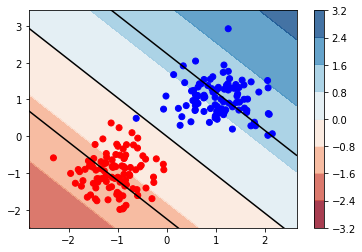

In [14]:
# pytorch
plot(X, Y, W=W_p_final, b=b_p_final.ravel())

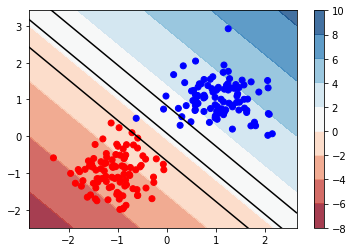

In [15]:
# sklearn
plot(X, Y, W=clf.coef_.T, b=clf.intercept_)

## Unleashing the power of PyTorch and TensorFlow

Actually we can get similar implementations much easier and especially much more extendible in both frameworks!! 

Let us start with **PyTorch** (we use a dataloader from `torch.utils.data` for the data pipeline, a class inheriting from `torch.nn.module` for the model, and an optimizer from `torch.optim`)

In [16]:
from torch.utils.data import TensorDataset, DataLoader

dataloader = DataLoader(TensorDataset(X_p, Y_p), shuffle=True, batch_size=10) # create dataloader
model = torch.nn.Linear(2,1) # create linear model
optimizer = torch.optim.SGD(model.parameters(), lr=0.1) # create SGD optimizer

print(f' W: {model.weight}')

 W: Parameter containing:
tensor([[ 0.3723, -0.0281]], requires_grad=True)


Training loop:

In [17]:
def train(epochs=100, C=1.):
    for _ in range(epochs):
        for X_batch, Y_batch in dataloader:
            optimizer.zero_grad() # zero the gradient buffers
            pred = model(X_batch)
            loss = C*hinge_loss(pred*Y_batch).mean() + (model.weight**2).sum()
            loss.backward() 
            optimizer.step() # does the update 

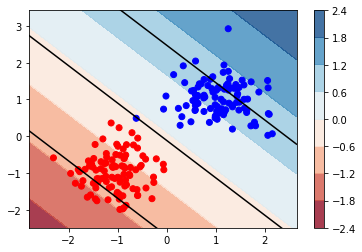

In [18]:
train()
plot(X, Y, W=model.weight.t().detach().numpy(), b=-model.bias.detach().numpy())

Lets switch to **Tensorflow/Keras**:

In [19]:
from tensorflow import keras

dataset = tf.data.Dataset.from_tensor_slices((X_t, Y_t)).shuffle(10).batch(10) # create dataset
model = keras.Sequential([keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(1.))]) # create model
model.compile(optimizer=tf.keras.optimizers.SGD(0.1), loss=tf.keras.losses.Hinge())
model.fit(dataset, epochs=100)

Train for 20 steps
Epoch 1/100
20/20 [==============================] - 0s 13ms/step - loss: 0.7317
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5349
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5365
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5339
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5340
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5346
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5352
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5338
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5363
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5327
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5357
Epoch 12/100
20/20 [==============================] - 0s 2ms/step - loss: 0.5349
Epoch 13/100
20/2

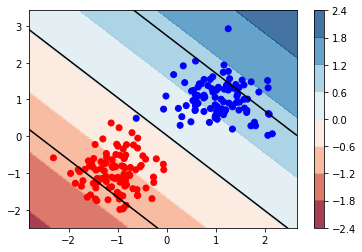

In [20]:
plot(X, Y, W=model.layers[0].kernel.numpy(), b=-model.layers[0].bias.numpy())

Further Material:

PyTorch: [What is torch.nn really?](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

Tensorflow: 

Visualization of Convolutional NN: [3D visualization of a Convolutional Neural Network for MNIST](https://www.cs.ryerson.ca/~aharley/vis/conv/)

Stack from fastai vienna course...